### Week 1 notebook

Each week, you will apply the concepts of that week to your Integrated Capstone Project’s dataset. In preparation for Milestone One, create a Jupyter Notebook (similar to in Module B, semester two) that illustrates these lessons. There are no specific questions to answer in your Jupyter Notebook files in this course; your general goal is to analyze your data, using the methods you have learned about in this course and in this program, and draw interesting conclusions. 

For Week 1, include concepts such as linear regression with polynomial terms, interaction terms, multicollinearity, variance inflation factor and regression, and categorical and continuous features. Complete your Jupyter Notebook homework by 11:59 pm ET on Sunday. 

In Week 7, you will compile your findings from your Jupyter Notebook homework into your Milestone One assignment for grading. For full instructions and the rubric for Milestone One, refer to the following link. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
# Analyzing the carclaims_cleaned dataset
df_car = pd.read_csv('C:/Users/JT von Seggern/DS Masters Repos/2025-spring-B2/data/carclaims_cleaned.csv')
pd.set_option('display.max_columns', None)
df_car.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [3]:
def encode_categories(df_or_series, cat_cols: list = None):
    """
    Encodes categorical columns in a DataFrame or a single pandas Series.

    Args:
        df_or_series: DataFrame or Series to encode.
        cat_cols: List of columns to encode (only used if input is DataFrame).

    Returns:
        If input is DataFrame: (encoded DataFrame, mappings dict)
        If input is Series: (encoded Series, mapping dict)
    """
    if isinstance(df_or_series, pd.Series):
        uniques = df_or_series.dropna().unique().tolist()
        mapping = {cat: code for code, cat in enumerate(uniques)}
        encoded = df_or_series.map(mapping).astype("int64")
        return encoded, mapping
    
    elif isinstance(df_or_series, pd.DataFrame):
        df_encoded = df_or_series.copy()
        mappings = {}
        if cat_cols is None:
            cat_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in cat_cols:
            uniques = df_encoded[col].dropna().unique().tolist()
            mapping = {cat: code for code, cat in enumerate(uniques)}
            mappings[col] = mapping
            df_encoded[col] = df_encoded[col].map(mapping).astype("int64")
        return df_encoded, mappings
    
    else:
        raise ValueError("Input must be a pandas DataFrame or Series.")

In [4]:
def one_hot_encode(df: pd.DataFrame, cat_cols: list = None) -> tuple[pd.DataFrame, list]:
    if cat_cols is None:
        cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    new_cols = [col for col in df_encoded.columns if col not in df.columns or col in cat_cols]
    return df_encoded, new_cols

In [5]:
# Convert categorical features to dummy variables
car_dum = df_car.copy()

# Split data into features and targets
X_car_dum = car_dum.drop(columns=['FraudFound'])
y_car_dum = car_dum['FraudFound']

# one hot the features
cat_feat = X_car_dum.select_dtypes(include=['object']).columns
X_car_encode, map = encode_categories(X_car_dum, cat_feat)

# encode the target
y_car_encode, map = encode_categories(y_car_dum, ['FraudFound'])

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate vif for each feature
vif_car_data = pd.DataFrame()
vif_car_data['Feature'] = X_car_encode.columns
vif_car_data['VIF'] = [variance_inflation_factor(X_car_encode.values, i) for i in range(len(X_car_encode.columns))]

# Sort the features by vif
vif_car_data = vif_car_data.sort_values(by='VIF', ascending=False)

# Display the vif data
vif_car_data

,Feature,VIF
29,Year,174.967540
12,PolicyType,116.822077
16,Deductible,91.617858
13,VehicleCategory,74.768882
28,NumberOfCars,17.599866
30,BasePolicy,14.921937
10,Age,13.456099
27,AddressChange-Claim,12.508655
8,Sex,6.494825
1,WeekOfMonth,6.179695


In [7]:
# Create a linear regression model using the info fro the vif analysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Only pick columns with a vif < 10
car_cols = list(vif_car_data[vif_car_data['VIF'] < 10]['Feature'])

# Split the data into train and test sets
X_car_train, X_car_test, y_car_train, y_car_test = train_test_split(X_car_encode[car_cols], y_car_encode, test_size=.2, random_state=0)

In [8]:
#Scale the data
from sklearn.preprocessing import StandardScaler
scaler_car = StandardScaler()
X_car_train_scaled = scaler_car.fit_transform(X_car_train)
X_car_test_scaled = scaler_car.fit_transform(X_car_test)

In [9]:
X_car_encode[car_cols].head()

,Sex,WeekOfMonth,WeekOfMonthClaimed,DriverRating,AgeOfVehicle,RepNumber,Month,MonthClaimed,MaritalStatus,AgeOfPolicyHolder,DayOfWeek,VehiclePrice,PastNumberOfClaims,DayOfWeekClaimed,Make,NumberOfSuppliments,Days:Policy-Accident,Days:Policy-Claim,Fault,AccidentArea,PoliceReportFiled,WitnessPresent,AgentType
0,0,5,1,1,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,4,4,1,15,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1,5,2,3,2,7,2,1,1,2,1,0,1,2,0,0,0,0,0,0,0,0,0
3,1,2,1,2,3,4,3,2,1,3,2,1,1,3,1,1,0,0,1,1,1,0,0
4,0,5,2,1,4,3,1,3,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0


In [10]:
# Create the logistic regression model
lm_car = LogisticRegression(class_weight='balanced').fit(X_car_train_scaled, y_car_train)

# Make predictions
y_car_pred = lm_car.predict(X_car_test_scaled)

# Score the model
score_car = lm_car.score(X_car_test_scaled, y_car_test)

# Display the results
print(f"Model Score: {score_car}")

Model Score: 0.5019455252918288


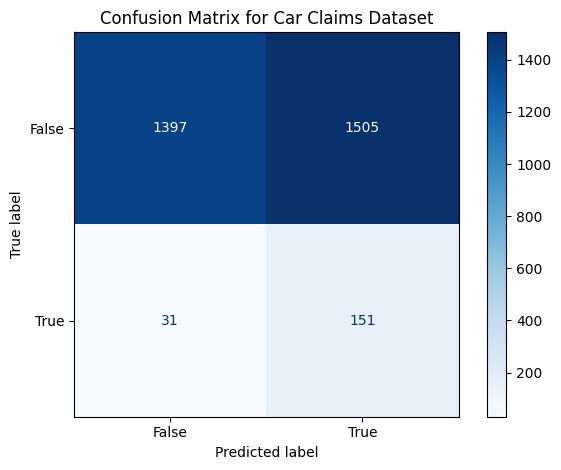

In [11]:
# Plot the confusion matrix
cm_car = confusion_matrix(y_car_test, y_car_pred)
disp_car = ConfusionMatrixDisplay(confusion_matrix=cm_car, display_labels=['False', 'True'])
disp_car.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Car Claims Dataset')
plt.tight_layout()
plt.show()

In [12]:
# Load the insurance claims dataset
df_ins = pd.read_csv("C:/Users/JT von Seggern/DS Masters Repos/2025-spring-B2/data/insurance_claims_cleaned.csv")
df_ins.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,?,Minor Damage,No authorities contacted,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,0


In [13]:
# Split the data into features and targets
X_ins = df_ins.drop(columns=['fraud_reported'])
y_ins = df_ins['fraud_reported']

In [14]:
# Encode all categorical features
ins_cat_feat = X_ins.select_dtypes(include=['object']).columns
X_ins_encoded, ins_map = encode_categories(X_ins, ins_cat_feat)

In [15]:
# Calculate vif for each feature
vif_ins_data = pd.DataFrame()
vif_ins_data['Feature'] = X_ins_encoded.columns
vif_ins_data['VIF'] = [variance_inflation_factor(X_ins_encoded.values, i) for i in range(len(X_ins_encoded.columns))]

# Sort the features by vif
vif_ins_data = vif_ins_data.sort_values(by='VIF', ascending=False)

# Display the vif data
vif_ins_data

c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
28,injury_claim,inf
27,total_claim_amount,inf
29,property_claim,inf
30,vehicle_claim,inf
33,auto_year,166.416587
1,age,131.686138
7,insured_zip,50.881748
0,months_as_customer,28.250718
5,policy_annual_premium,28.077538
22,number_of_vehicles_involved,13.428271


In [16]:
# Only pick columns with a vif < 10
ins_cols = list(vif_ins_data[vif_ins_data['VIF'] < 10]['Feature'])

# Split the data into train and test sets
X_ins_train, X_ins_test, y_ins_train, y_ins_test = train_test_split(X_ins_encoded[ins_cols], y_ins, test_size=.2, random_state=0)

In [17]:
#Scale the data
scaler_ins = StandardScaler()
X_ins_train_scaled = scaler_ins.fit_transform(X_ins_train)
X_ins_test_scaled = scaler_ins.fit_transform(X_ins_test)

In [18]:
# Create the logistic regression model
lm_ins = LogisticRegression().fit(X_ins_train_scaled, y_ins_train)

# Make predictions
y_ins_pred = lm_ins.predict(X_ins_test_scaled)

# Score the model
score_ins = lm_ins.score(X_ins_test_scaled, y_ins_test)

# Display the results
print(f"Model Score: {score_ins}")

Model Score: 0.75


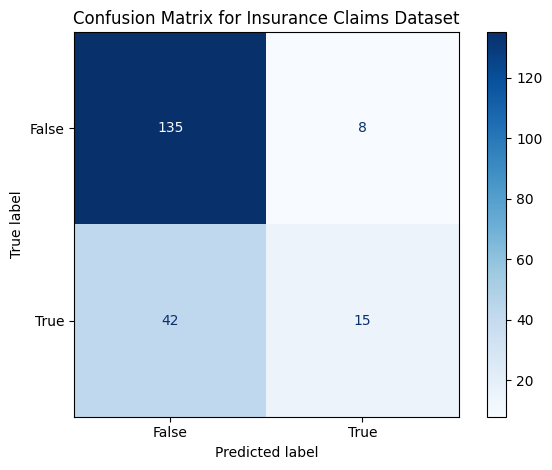

In [19]:
# Plot the confusion matrix
cm_ins = confusion_matrix(y_ins_test, y_ins_pred)
disp_ins = ConfusionMatrixDisplay(confusion_matrix=cm_ins, display_labels=['False', 'True'])
disp_ins.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Insurance Claims Dataset')
plt.tight_layout()
plt.show()

In [20]:
# load the fast, furious, and insured dataset
df_fur = pd.read_csv(r'C:\Users\JT von Seggern\DS Masters Repos\799S-Data-Science-Capstone\Fast_Furious_Insured\train_cleaned.csv')
df_fur.head()

,Insurance_company,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Expiry_year,Expiry_month,Expiry_day,Amount
0,BQ,41500.0,1037.5,36142.68,0,2026,12,3,0.0
1,BQ,50700.0,1267.5,12753.00,1,2025,7,10,6194.0
2,A,49500.0,1237.5,43102.68,0,2022,8,11,0.0
3,A,33500.0,837.5,8453.00,1,2022,8,2,7699.0
4,AC,27600.0,690.0,6978.00,1,2026,5,1,8849.0


In [21]:
df_fur.info()
df_fur.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1301 entries, 0 to 1300
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Insurance_company  1301 non-null   object 
 1   Cost_of_vehicle    1301 non-null   float64
 2   Min_coverage       1301 non-null   float64
 3   Max_coverage       1301 non-null   float64
 4   Condition          1301 non-null   int64  
 5   Expiry_year        1301 non-null   int64  
 6   Expiry_month       1301 non-null   int64  
 7   Expiry_day         1301 non-null   int64  
 8   Amount             1301 non-null   float64
dtypes: float64(4), int64(4), object(1)
memory usage: 91.6+ KB


,Cost_of_vehicle,Min_coverage,Max_coverage,Condition,Expiry_year,Expiry_month,Expiry_day,Amount
count,1301.000000,1301.000000,1301.000000,1301.000000,1301.000000,1301.000000,1301.000000,1301.000000
mean,37472.328978,936.808224,11259.900046,0.925442,2024.928517,6.710223,15.701768,4105.472713
std,8918.789321,222.969733,7183.175604,0.262778,2.127540,3.572949,8.541856,3198.868399
min,11100.000000,277.500000,2853.000000,0.000000,2021.000000,1.000000,1.000000,0.000000
25%,29800.000000,745.000000,7603.000000,1.000000,2023.000000,4.000000,8.000000,1316.000000
50%,37300.000000,932.500000,9678.000000,1.000000,2025.000000,7.000000,16.000000,4048.000000
75%,45200.000000,1130.000000,11703.000000,1.000000,2027.000000,10.000000,23.000000,6056.000000
max,53500.000000,1337.500000,46495.680000,1.000000,2028.000000,12.000000,31.000000,59844.000000


In [22]:
df_fur = df_fur[(df_fur['Amount'] > 0) & (df_fur['Amount'] < 15000)]


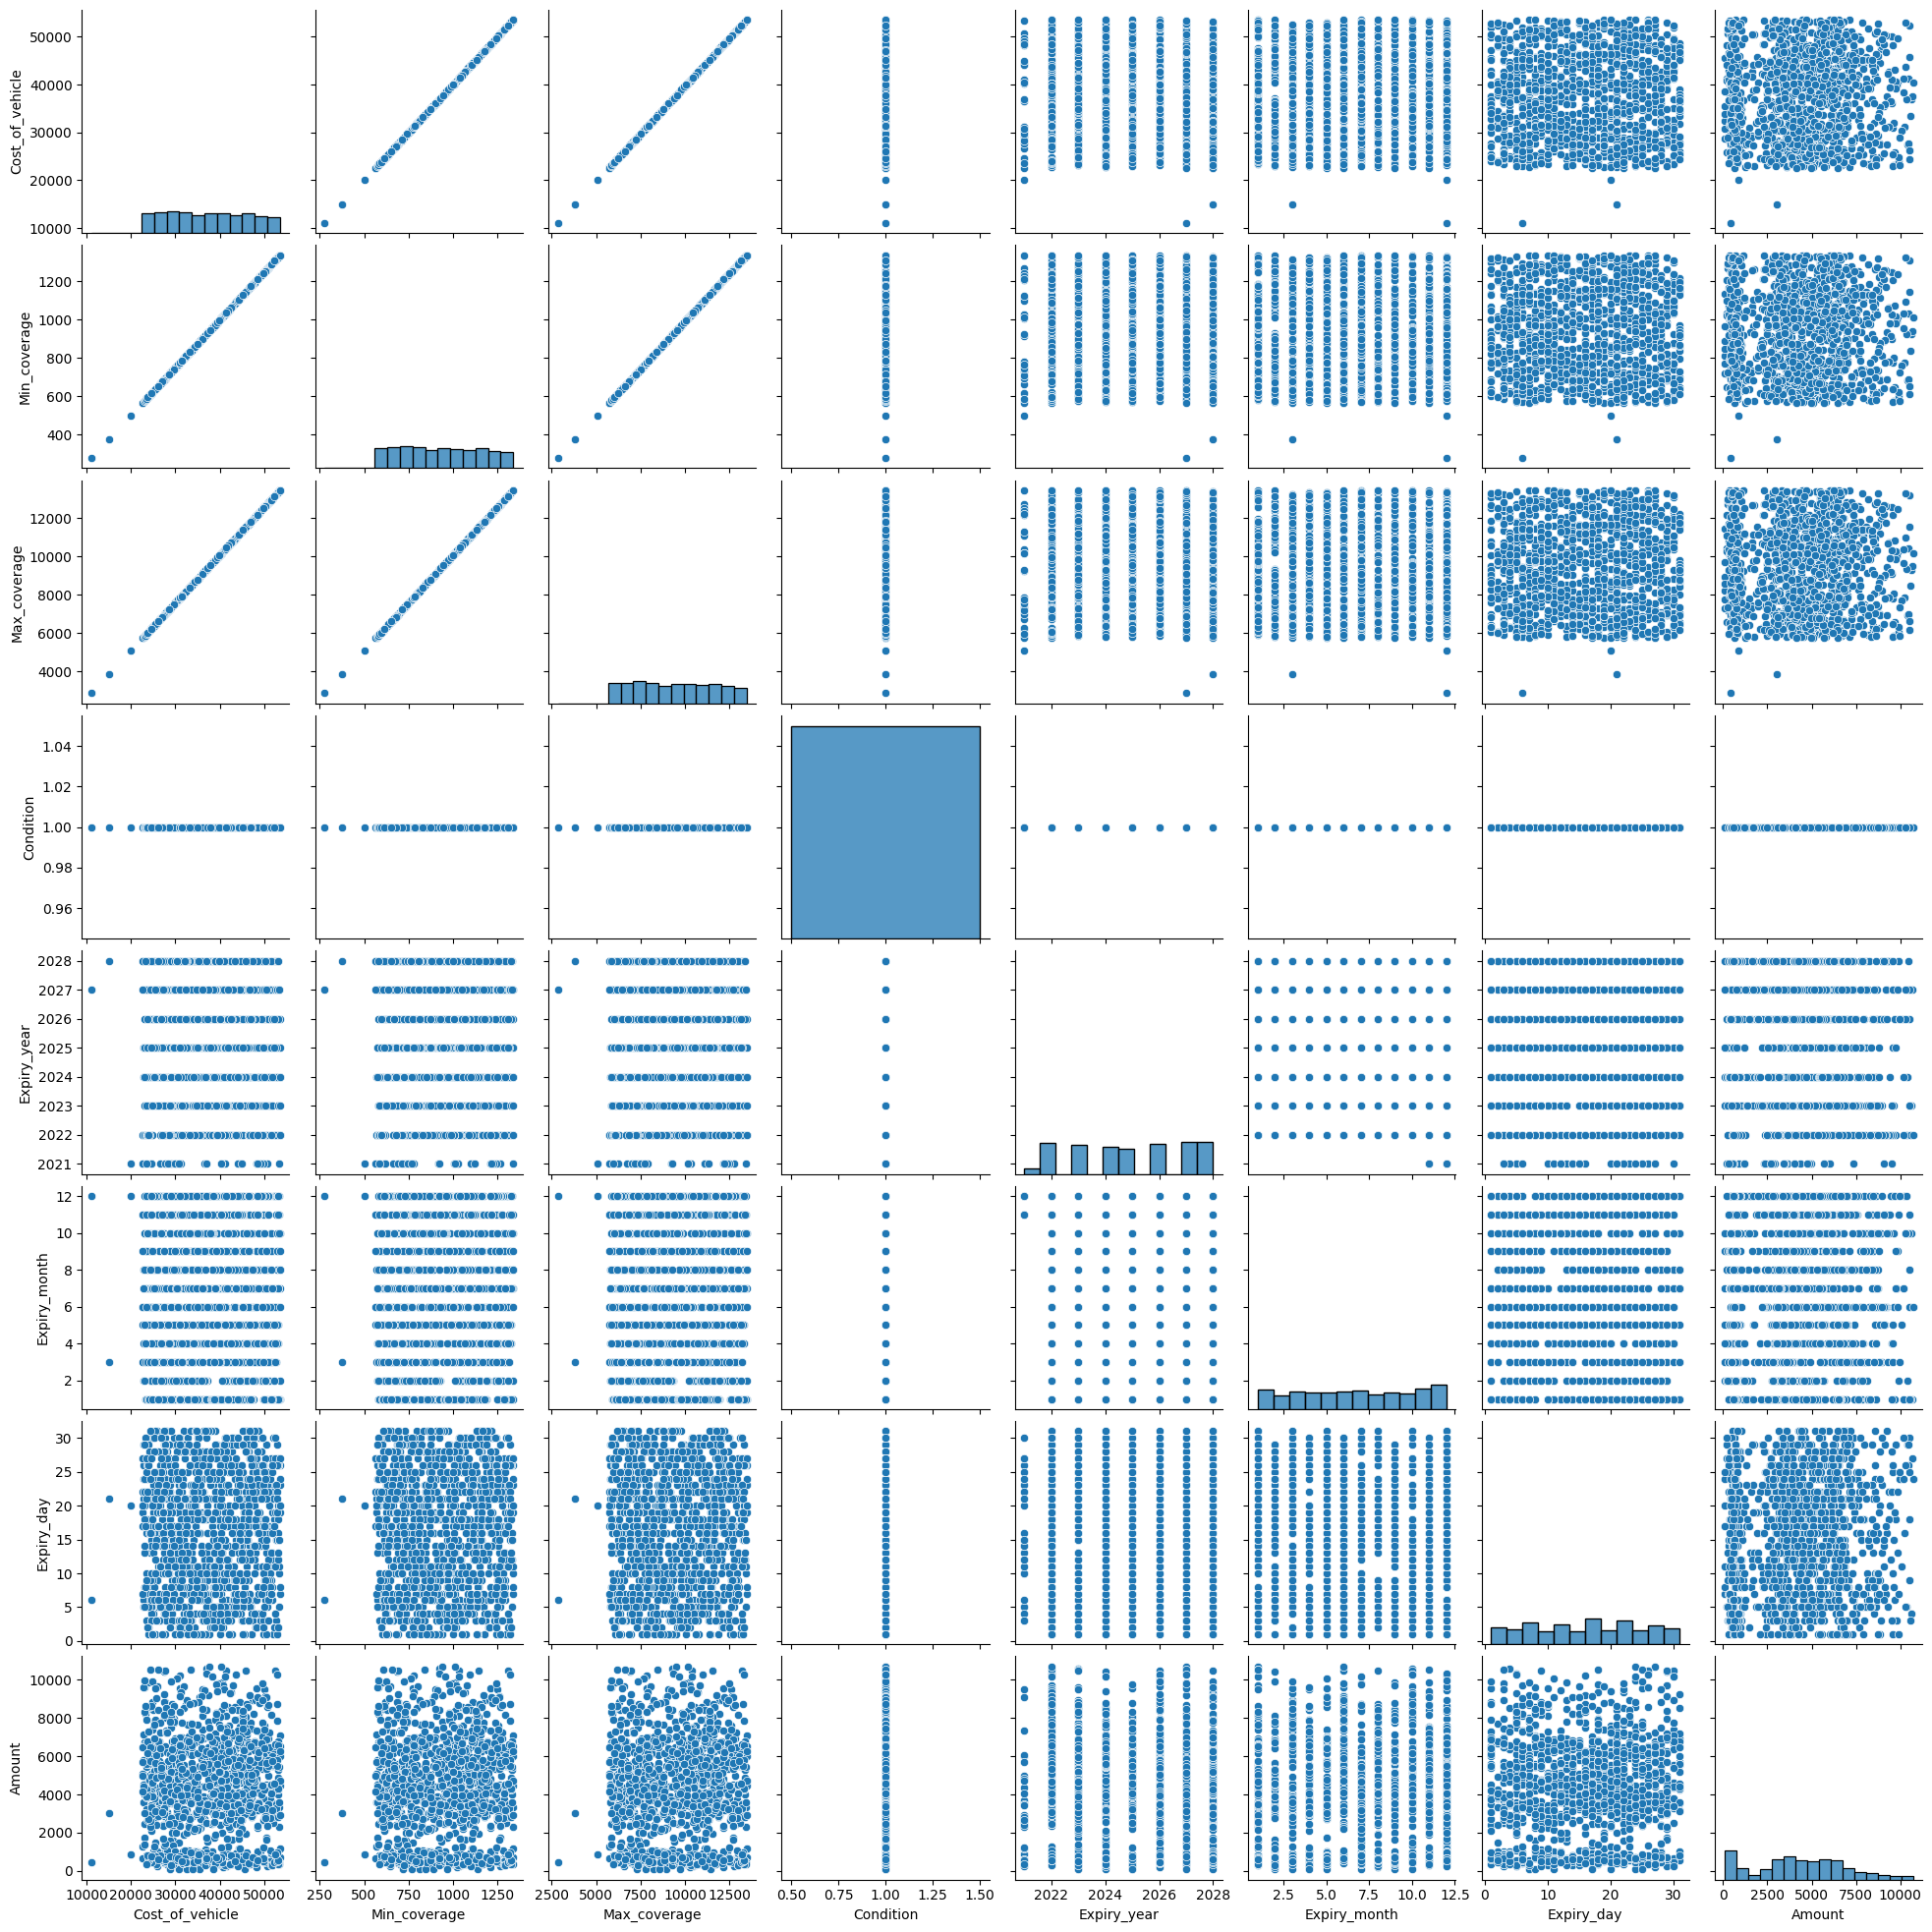

In [23]:
sns.pairplot(df_fur)

In [24]:
# Split the data into features and target
X_fur = df_fur.drop(columns=['Amount'])
y_fur = df_fur['Amount']

In [25]:
# Encode features
fur_cat_feat = X_fur.select_dtypes(include=['object']).columns
X_fur_encoded, fur_map = encode_categories(X_fur, fur_cat_feat)

In [26]:
# Calculate vif for each feature
vif_fur_data = pd.DataFrame()
vif_fur_data['Feature'] = X_fur_encoded.columns
vif_fur_data['VIF'] = [variance_inflation_factor(X_fur_encoded.values, i) for i in range(len(X_fur_encoded.columns))]

# Sort the features by vif
vif_fur_data = vif_fur_data.sort_values(by='VIF', ascending=False)

# Display the vif data
vif_fur_data

c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,Feature,VIF
1,Cost_of_vehicle,inf
2,Min_coverage,inf
3,Max_coverage,inf
6,Expiry_month,1.009497
0,Insurance_company,1.005843
5,Expiry_year,1.004932
7,Expiry_day,1.001787
4,Condition,0.000000


In [27]:
# Only pick columns with a vif < 10
fur_cols = list(vif_fur_data[vif_fur_data['VIF'] < 10]['Feature'])

# Split the data into train and test sets
X_fur_train, X_fur_test, y_fur_train, y_fur_test = train_test_split(X_fur_encoded[fur_cols], y_fur, test_size=.2, random_state=0)

# Scale the data
scaler_fur = StandardScaler()
X_fur_train_scaled = scaler_fur.fit_transform(X_fur_train)
X_fur_test_scaled = scaler_fur.fit_transform(X_fur_test)

In [28]:
# Create the logistic regression model
lm_fur = LinearRegression().fit(X_fur_train_scaled, y_fur_train)

# Make predictions
y_fur_pred = lm_fur.predict(X_fur_test_scaled)

# Score the model
score_fur = lm_fur.score(X_fur_test_scaled, y_fur_test)

# Display the results
print(f"Model Score: {score_fur}")

Model Score: -0.013836884704926389


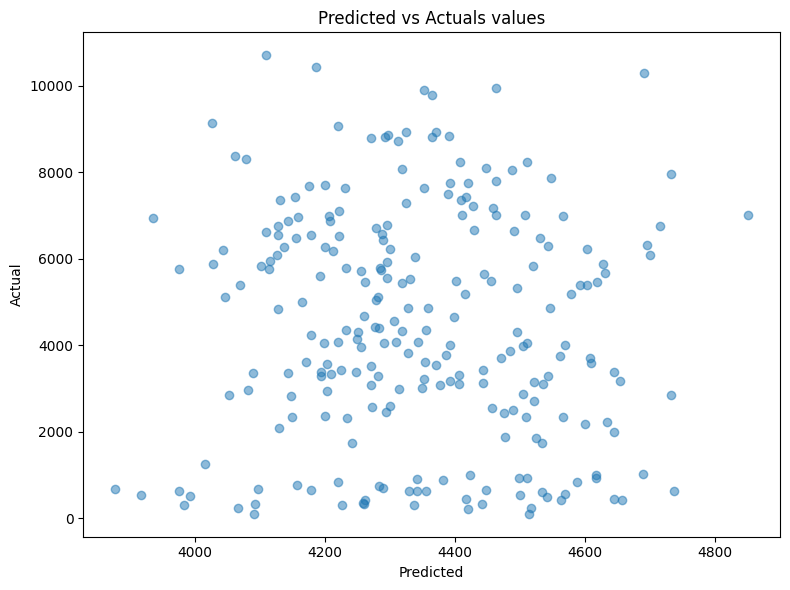

In [29]:
# Plot the results of the furious dataset
plt.figure(figsize=(8,6))
plt.scatter(y_fur_pred, y_fur_test, alpha=.5)
plt.title("Predicted vs Actuals values")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

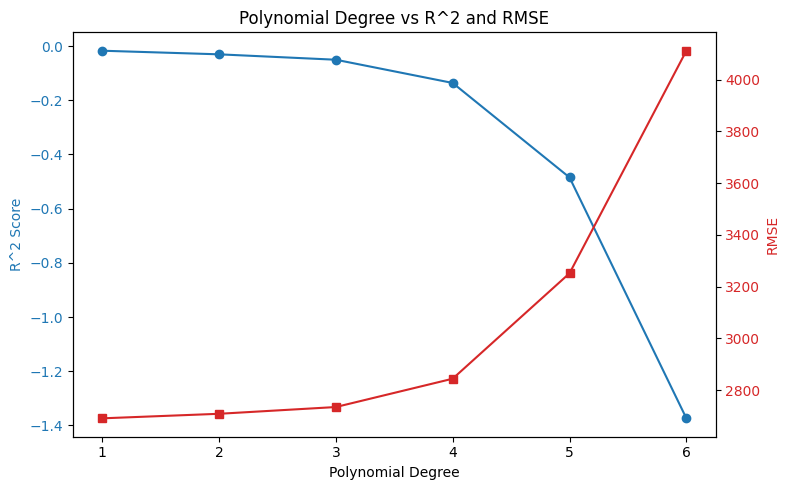

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, root_mean_squared_error

def poly_regression_results(df, target_col='Amount', max_degree=3, test_size=0.2, random_state=0):
    
    # Prepare features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Encode categorical features
    cat_cols = X.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        X, _ = encode_categories(X, cat_cols)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    results = []
    for degree in range(1, max_degree + 1):
        poly = PolynomialFeatures(degree=degree)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_test_poly = poly.transform(X_test_scaled)
        
        model = LinearRegression().fit(X_train_poly, y_train)
        y_pred = model.predict(X_test_poly)
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        results.append({'degree': degree, 'r2': r2, 'rmse': rmse})
    
    results_df = pd.DataFrame(results)

    # Plot R2 and RMSE
    fig, ax1 = plt.subplots(figsize=(8,5))

    color = 'tab:blue'
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('R^2 Score', color=color)
    ax1.plot(results_df['degree'], results_df['r2'], marker='o', color=color, label='R^2')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(results_df['degree'])

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('RMSE', color=color)
    ax2.plot(results_df['degree'], results_df['rmse'], marker='s', color=color, label='RMSE')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Polynomial Degree vs R^2 and RMSE')
    fig.tight_layout()
    plt.show()
    
    return results_df

# Example usage:
poly_results = poly_regression_results(df_fur, target_col='Amount', max_degree=6)